In [211]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from laser_parallax import *

In [213]:
# cam_intrinsics = {'f': 4.5 * 1e-3, 'center': np.array([4000, 3000]), 'w': 1.5 * 1e-6}
sensor_size_px = np.array([4000, 3000])
pixel_pitch_mm = 0.0015
focal_length_mm = 4.5
camera_params = (focal_length_mm, sensor_size_px[0], sensor_size_px[1], pixel_pitch_mm)

Given we have $n$ laser dots with the world coordinates of point $i$ being $p_i\in \mathbb{R}^3$, we define 
$$\bm{p} = \begin{bmatrix}p_1 \\ p_2 \\\vdots \\p_n\end{bmatrix}$$
The below function obtains the Jacobian of
$$ \hat{f}(\bm{p}, \alpha, \ell) = \begin{bmatrix} f(p_1, \alpha, \ell) \\ f(p_2, \alpha, \ell) \\ \vdots \\ f(p_n, \alpha, \ell) \end{bmatrix}  $$
with respect to $\alpha$ and $\ell$, where
$$ f(p_i, \alpha, \ell) = \lVert p_i - \ell \lVert \alpha + \ell $$
The Jacobian $J_f$ can be broken up into the following block matrices
$$ J_f = \begin{bmatrix} 
            J^1_{f\alpha} & J^1_{f\ell} \\
            J^2_{f\alpha} & J^2_{f\ell} \\
            \vdots & \vdots \\
            J^n_{f\alpha} & J^n_{f\ell}
         \end{bmatrix},$$
where 
$$ J^i_{f\alpha} = ||p_i - \ell|| I \in \mathbb{R}^{3\times 3}$$  
$$ J^i_{f\ell} = \begin{bmatrix} I_{2\times 2} \\ 0\end{bmatrix}(I_{3\times3} - \alpha(p_i - \ell)^T) \in \mathbb{R}^{3\times 2} $$

In [214]:
def get_jacobian(
        ps: np.ndarray, 
        state: np.ndarray) -> np.ndarray:
    n = ps.shape[0]
    jacobian = np.zeros((n * 3, 5))
    alpha = state[:3]
    l = np.array([state[3], state[4], 0])
    for i in range(n):
        p = ps[i]
        jacobian[3*i:3*i+3,:3] = np.eye(3) * np.linalg.norm(p - l)
        jacobian[3*i:3*i+3,3:5] = alpha[:,np.newaxis] @ (l - p)[np.newaxis,:2]
        jacobian[[3*i,3*i+1],[3,4]] += 1
    return jacobian

In [215]:
def get_residual(
    points: np.ndarray,
    state: np.ndarray) -> float:
    laser_pos = np.array([state[3], state[4], 0])
    laser_angle = state[:3]
    est_points = np.linalg.norm(points - laser_pos, axis=1)[:, np.newaxis] * laser_angle + laser_pos
    return points - est_points

In [218]:
depths = np.zeros(49)
img_coords = np.zeros((49,2))
with open('data_rectified.csv','r',encoding='utf-8-sig') as csvfile: 
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader: 
        idx = int(row[''])
        depths[idx] = float(row['dist'])
        img_coords[idx,0] = int(row['X'])
        img_coords[idx,1] = int(row['Y'])


In [332]:
state_init = np.array([0,0,1,-0.04,-0.11])
ps = compute_world_points_from_depths(
    camera_params=camera_params,
    image_coordinates=(sensor_size_px/2 - img_coords),
    depths=depths/100
)

The Gauss-Newton algorithm minimizes problems of the form
$$ S = \sum_i r_i(\beta)^2 $$ 
In our case, we have defined 
$$ \hat{r}(\bm{p},\alpha,\ell) = \begin{bmatrix}r(p_i,\alpha,\ell) \\ \vdots \\ r(p_n, \alpha, \ell)\end{bmatrix},$$ 
where $r(p_i, \alpha, \ell) = p_i - f(p_i, \alpha, \ell)$. We are looking to solve
$$\min_{\alpha,\ell}\lVert\bm{p} - \hat{f}(\bm{p},\alpha,\ell)\rVert. $$
We define $x^{(k)} = \left[ \alpha^{(k)} \space \ell^{(k)}\right]^T$.
Given that we know the Jacobian $J_r$ of $\hat{r}$ w.r.t $\alpha$ and $\ell$, the Gauss-Newton algorithm minimizes this by the following iterations: 
$$x^{(k+1)} = x^{(k)} - (J_r^T J_r)J_r^T\hat{r}(\bm{p},\alpha,\ell)$$

Since we know that $\hat{r}(\bm{p},\alpha,\ell) = \bm{p} - \hat{f}(\bm{p},\alpha,\ell)$, $J_f = -J_r$, and

$$x^{(k+1)} = x^{(k)} + (J_f^T J_f)J_f^T\hat{r}(\bm{p},\alpha,\ell)$$

In [326]:
def gauss_newton_estimate_state(
        ps: np.ndarray, 
        init_state: np.ndarray, 
        num_iterations: int =10) -> np.ndarray:
    state = init_state
    for _ in range(num_iterations):
        J = get_jacobian(ps, state)
        rs = get_residual(ps, state).flatten()
        temp_state = state + np.linalg.pinv(J) @ rs
        state = temp_state
        alpha_norm = temp_state[0]**2 + temp_state[1]**2 + temp_state[2]**2
        print(f"Current state: {state}")
        print(f"Norm squared of alpha: {alpha_norm}")
        print(f"Current squared error of residual: {np.sum(rs**2)}")
    return state

state = gauss_newton_estimate_state(ps, state_init, num_iterations=100)

Current state: [-0.01102016 -0.02216317  0.99949953 -0.02690433 -0.09989634]
Norm squared of alpha: 0.9996119549161141
Current squared error of residual: 0.18328541734433224
Current state: [-0.01102139 -0.02216356  0.9996927  -0.02689671 -0.0998881 ]
Norm squared of alpha: 0.9999981858447189
Current squared error of residual: 0.0006342975186154377
Current state: [-0.0110214  -0.02216357  0.99969289 -0.02689671 -0.0998881 ]
Norm squared of alpha: 0.9999985603929455
Current squared error of residual: 0.0006182230686994323
Current state: [-0.0110214  -0.02216357  0.99969289 -0.02689671 -0.0998881 ]
Norm squared of alpha: 0.999998560610759
Current squared error of residual: 0.0006182230538328803
Current state: [-0.0110214  -0.02216357  0.99969289 -0.02689671 -0.0998881 ]
Norm squared of alpha: 0.9999985606108874
Current squared error of residual: 0.0006182230538330029
Current state: [-0.0110214  -0.02216357  0.99969289 -0.02689671 -0.0998881 ]
Norm squared of alpha: 0.9999985606108874
Curr

In [327]:
laser_pos = np.array([state[3], state[4], 0])
laser_angle = state[:3]
dots_from_laser_origin = np.linalg.norm(ps - laser_pos, axis=1)[:,np.newaxis] * laser_angle + laser_pos

Text(0.5, 1.0, 'Actual distance vs distance based on estimated parameters')

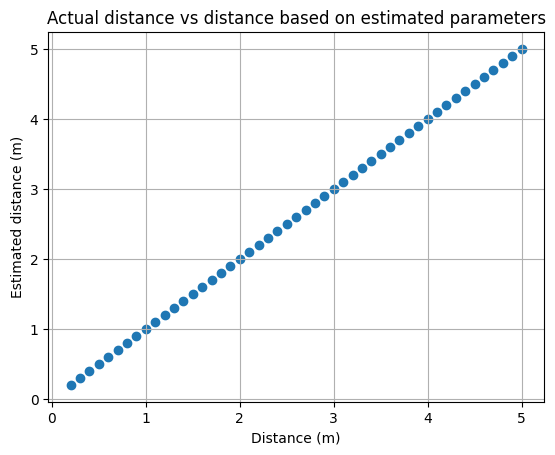

In [328]:
plt.scatter(ps[:,2], dots_from_laser_origin[:,2])
plt.grid()
plt.xlabel('Distance (m)')
plt.ylabel('Estimated distance (m)')
plt.title('Actual distance vs distance based on estimated parameters')


Text(0, 0.5, 'Percentage difference of norm (%)')

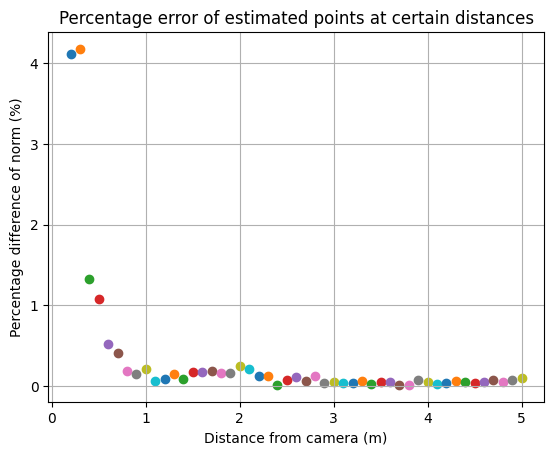

In [321]:
for i in range(49):
    plt.scatter(ps[i,2], np.linalg.norm(dots_from_laser_origin[i] - ps[i])/np.linalg.norm(ps[i]) * 100)
plt.grid()
plt.title('Percentage error of estimated points at certain distances')
plt.xlabel('Distance from camera (m)')
plt.ylabel('Percentage difference of norm (%)')

In [325]:
print(f'Laser Offset: {laser_pos}')
print(f'Laser Axis: {laser_angle}')

Laser Offset: [-0.02689671 -0.0998881   0.        ]
Laser Axis: [-0.0110214  -0.02216357  0.99969289]
